# Group 2 Project. Sequence - to Sequence learning for langauge translation

**This file was forked from https://github.com/bentrevett/pytorch-seq2seq/blob/main/README.md and modified to support russian lanaguage and dataset**

## Introduction

The most common sequence-to-sequence (seq2seq) models are _encoder-decoder_ models, which commonly use a _recurrent neural network_ (RNN) to _encode_ the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a _context vector_. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then _decoded_ by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

![](assets/seq2seq1.png)

The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). We also append a _start of sequence_ (`<sos>`) and _end of sequence_ (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an _LSTM_ (Long Short-Term Memory) or a _GRU_ (Gated Recurrent Unit).

Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN via the embedding layer, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$.

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called _teacher forcing_, see a bit more info about it [here](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/).

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.


## Preparing Data

First up, importing all the necessary libraries. The main ones we'll be using are:

-   [PyTorch](https://pytorch.org/) for creating the models
-   [spaCy](https://spacy.io/) to assist in the tokenization of the data
-   [torchtext](https://github.com/pytorch/text) to provider some helper functions
-   [datasets](https://huggingface.co/docs/datasets/index) to load and manipulate our data
-   [evaluate](https://huggingface.co/docs/evaluate/index) for calculating metrics


In [ ]:
# NOTE: If you are running this notebook on Google Colab,
#       then uncomment the two lines below and then run this cell!
!pip install pyarrow==12.0.0;
!pip install torchtext torch datasets evaluate spacy;
!python -m spacy download ru_core_news_sm;
!python -m spacy download en_core_web_sm;


2024-02-16 20:44:58.158281: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 20:44:58.209547: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 20:44:58.209620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 20:44:58.210996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 20:44:58.218935: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
!pip install datasets;

In [ ]:
!pip install evaluate

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm
import evaluate

We'll set all possible random seeds for deterministic results.


In [ ]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

### Dataset

Next, we'll load our dataset using the `datasets` library. When using the `load_dataset` function we pass the name of the dataset, `gem`.


In [ ]:
dataset = datasets.load_dataset("gem", "wiki_lingua_ru_en_v0");

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for gem contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/gem
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/36898 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9094 [00:00<?, ? examples/s]

We can see the `dataset` object (a `DatasetDict`) contains the train, validation and test splits, the amount of examples in each split, and the features in each split ("en" and "de").


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source', 'target', 'references'],
        num_rows: 36898
    })
    validation: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source', 'target', 'references'],
        num_rows: 4100
    })
    test: Dataset({
        features: ['gem_id', 'gem_parent_id', 'source', 'target', 'references'],
        num_rows: 9094
    })
})

For convenience, we create a variable for each split. Each being a `Dataset` object.


In [ ]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

We can index into each `Dataset` to view an individual example. Each example has two features: "en" and "ru", which are the parallel English and Russian sentences.


In [ ]:
train_data[0];

### Tokenizers

Next, we'll load the spaCy models that contain the tokenizers.

A tokenizer is used to turn a string into a list of tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"]. We'll start talking about the sentences being a sequence of tokens from now, instead of saying they're a sequence of words. What's the difference? Well, "good" and "morning" are both words and tokens, but "!" is not a word. We could say "!" is punctuation, but the term token is more general and covers: words, punctuation, numbers and any special symbols.

spaCy has model for each language ("ru_core_news_sm" for Russian and "en_core_web_sm" for English) which need to be loaded so we can access the tokenizer of each model.

**Note**: the models must first be downloaded using the following on the command line:

```
python -m spacy download en_core_web_sm
python -m spacy download ru_core_news_sm
```

We load the models as such:


In [ ]:
en_nlp = spacy.load("en_core_web_sm");
ru_nlp = spacy.load("ru_core_news_sm");

We can call the tokenizer for each spaCy model using the `.tokenizer` method, which accepts a string and returns a sequence of `Token` objects. We can get the string from the token object using the `text` attribute.


In [ ]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

Next, we'll write a function used to apply the tokenizer to all of the examples in each data split, as well as apply some other processing.

This function takes in an example from the `Dataset` object, applies the tokenizers English and Russian spaCy models, trims the list of tokens to a maximum length, optionally converts each token to lowercase, and then appends the start of sequence and end of sequence tokens to the beginning and end of the list of tokens.

This function will be used with the `map` method from a `Dataset`, which needs to return a dictionary containing the names of the features in each example where the outputs are stored. As the output feature names "en_tokens" and "de_tokens" are not already contained in the example (where we only have "en" and "de" features), this will create two new features in each example.


In [ ]:
def tokenize_example(example, en_nlp, ru_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["target"])][:max_length]
    ru_tokens = [token.text for token in ru_nlp.tokenizer(example["source"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        ru_tokens = [token.lower() for token in ru_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    ru_tokens = [sos_token] + ru_tokens + [eos_token]
    return {"en_tokens": en_tokens, "ru_tokens": ru_tokens}

We apply the `tokenize_example` function using the `map` method as below.

The `example` argument is implied, however all additional arguments to the `tokenize_example` function need to be stored in a dictionary and passed to the `fn_kwargs` argument of `map`.

Here, we're trimming all sequences to a maximum length of 1000 tokens, converting each token to lower case, and using `<sos>` and `<eos>` as the start and end of sequence tokens, respectively.


In [ ]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "ru_nlp": ru_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs);
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs);
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs);

Map:   0%|          | 0/36898 [00:00<?, ? examples/s]

Map:   0%|          | 0/4100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9094 [00:00<?, ? examples/s]

We can now look at an example, confirming the two new features have been added; both of which are lowercased list of strings with the start/end of sequence tokens appended.


In [ ]:
train_data[0]

{'gem_id': 'wiki_lingua_ru_en_v0-train-0',
 'gem_parent_id': 'wiki_lingua_ru_en_v0-train-0',
 'source': 'Если вы хотите получить эмансипацию, то вам нужны будут доказательства в суде, что вы финансово независимы и что у вас есть работа. Если таковой у вас нет, то найдите ее как можно скорее.  Составьте резюме, в которое войдет ваша предыдущая работа, волонтерство, кружки и другие виды деятельности. Поищите в местной газете предложения работы, где не требуется аттестат среднего образования. Экономьте как можно больше денег. Не тратьте деньги на одежду и развлечения. Покупайте нужные вам вещи в подержанном состоянии или пытайтесь достать их бесплатно. Делайте покупки экономно; покупайте дешевые продукты — бобы, капусту, тунец. Откройте сберегательный счет в местном банке. Если вы стремитесь к эмансипации, то в суде нужно будет показать, что вы имеете постоянное место жительства. Возможно, вы не сможете позволить себе дом; обратите внимание на маленькие дешевые квартирки или заключите пос

### Vocabularies

Next, we'll build the _vocabulary_ for the source and target languages. The vocabulary is used to associate each unique token in our dataset with an index (an integer), e.g. "hello" = 1, "world" = 2, "bye" = 3, "hates" = 4, etc. When feeding text data to our model, we convert the string into tokens and then the tokens into numbers using the vocabulary as a look up table, e.g. "hello world" becomes `["hello", "world"]` which becomes `[1, 2]` using the example indices given. We do this as neural networks cannot operate on strings, only numerical values.

We create the vocabulary (one for each language) from our datasets using the `build_vocab_from_iterator` function, provided by `torchtext`, which accepts an iterator where each item is a list of tokens. It then counts up the number of unique tokens and assigns each a numerical value.

In theory, our vocabulary can be large enough to have an index for every unique token in our dataset. However, what happens if a token exists in our validation and test set, but not in our training set? In that case, we replace the token with an "unknown token", denoted by `<unk>`, which is given its own index (usually index zero). All unknown tokens are replaced by `<unk>`, even if the tokens are different, i.e. if the tokens "gilgamesh" and "enkidu" were both not within our vocabulary, then the string "gilgamesh hates enkidu" gets tokenized to `["gilgamesh", "hates", "enkidu"]` and then becomes `[0, 24, 0]` (where "hates" has the index 24).

Ideally, we want our model to be able to handle unknown tokens by learning to use the context around them to make translations. The only way it can learn that is if we also have unknown tokens in the training set. Hence, when creating our vocabularies with `build_vocab_from_iterator`, we use the `min_freq` argument to not create an index for tokens which appear less than `min_freq` times in our training set. In other words, when using the vocabulary, any token which does not appear at least twice in our training set will get replaced by the unknown token index when converting tokens to indices.

It is important to note that a vocabulary should only be built from the training set and never the validation or test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

We also use the `specials` argument of `build_vocab_from_iterator` to pass _special tokens_. These are tokens which we want to add to the vocabulary but do not necessarily appear in our tokenized examples. These special tokens will appear first in the vocabulary. We've already discussed the `unk_token`, `sos_token`, and `eos_token`. The final special token is the `pad_token`, denoted by `<pad>`.

When inputting sentences into our model, it is more efficient to pass multiple sentences at once (known as a batch), instead of one at a time. The requirement for sentences to be batched together is that they all have to be the same length (in terms of the number of tokens). The majority of our sentences are not the same length, but we can solve this by "padding" (adding `<pad>` tokens) the tokenized version of each sentence in a batch until they all have equal tokens to the longest sentence in the batch. For example, if we had two sentences: "I love pizza" and "I hate music videos". They would be tokenized to something like: `["i", "love", "pizza"]` and `["i", "hate", "music", "videos"]`. The first sequence of tokens would then be padded to `["i", "love", "pizza", "<pad>"]`. Both sequences could then be converted to indexes using the vocabulary.

That was a lot of information, but luckily `torchtext` handles all the fuss of building the vocabulary. We'll handle the padding and batching later.


In [ ]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

ru_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["ru_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

Now we have our vocabularies, we can check what's actually in them.

We can get the first ten tokens in our vocabulary (indices 0 to 9) using the `get_itos` method, where itos = "**i**nt **to** **s**tring", which returns a list of tokens.


In [ ]:
en_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '.', 'the', 'your', 'a', 'to', 'and']

In [ ]:
en_vocab.get_itos()[9]

'and'

We can do the same for the Russian vocabulary. Notice how the special tokens are the same and in the same order (indices 0 to 3), however the rest are different. This is because the vocabularies were effectively created from different data (one English and one Russian) even though they were from the same examples. The indices given to tokens that are not special tokens are ordered from most frequent to least frequent (though still appearing at least `min_freq` times).


In [ ]:
ru_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'и', 'в', 'вы', 'не']

We can get the index from a given token using the `get_stoi` (stoi = " **s**tring **to** **i**nt) method.


In [ ]:
en_vocab.get_stoi()["the"]

5

As a shorthand, we can just use the vocabulary as a dictionary and pass the token to get the index. Note that this doesn't work the other way around, i.e. `en_vocab[7]` does not work.


In [ ]:
en_vocab["the"]

5

The `len` of each vocabulary gives us the number of unique tokens in each one. We can see that our training data had around 2000 more Russian tokens (that appeared at least twice) than the English data.


In [ ]:
len(en_vocab), len(ru_vocab)

(18151, 151654)

We can also use the `in` keyword to get a boolean indicating if a token is in the vocabulary.


In [ ]:
"the" in en_vocab

True

Remember how we converted all of our tokens to lowercase? This means that no tokens containing any uppercase characters appear in our vocabulary.


In [ ]:
"The" in en_vocab

False

What happens if you try and get the index of a token that isn't in the vocabulary? You get index zero for the `<unk>` (unknown) token, right?

Well, no. One quirk of the `torchtext` vocabulary class is that you have to manually set what value you want your vocabulary to return when you try and get the index of an out-of-vocabulary token. If you have not set this value, then you will receive an error! This is so you can set your vocabulary to return any value when trying to get the index of a token not in the vocabulary, even something like `-100`.


In [ ]:
# en_vocab["The"]

We already know the index of our `<unk>` token is zero as it's the first element in our `special_tokens` list, and we've also manually inspected it using `get_itos`.

However, here we'll programmatically get it and also check that both our vocabularies have the same index for the unknown and padding tokens as this simplifies some code later on.

We also get the index of our `<pad>` token, as we'll use it later


In [ ]:
assert en_vocab[unk_token] == ru_vocab[unk_token]
assert en_vocab[pad_token] == ru_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

Using the `set_default_index` method we can set what value is returned when we try and get the index of a token outside of our vocabulary. In this case, the index of the unknown token, `<unk>`.


In [ ]:
en_vocab.set_default_index(unk_index)
ru_vocab.set_default_index(unk_index)

Now, we can happily get indexes of out of vocabulary tokens until our heart is content!


In [ ]:
en_vocab["The"]

0

And we can get the token corresponding to that index to prove it's the `<unk>` token.


In [ ]:
en_vocab.get_itos()[0]

'<unk>'

Another useful feature of the vocabulary is the `lookup_indices` method. This takes in a list of tokens and returns a list of indices. In the below example we can see the token "crime" does not exist in our vocabulary so is coverted to the index of the `<unk>` token, zero, which we passed to the `set_default_index` method.


In [ ]:
tokens = ["i", "love", "watching", "crime", "shows"]

In [ ]:
en_vocab.lookup_indices(tokens)

[937, 438, 5160, 5418, 2342]

Conversely, we can use the `lookup_tokens` method to convert a list of indices back into tokens using the vocabulary. Notice how the original "crime" token is now an `<unk>` token. There is no way to tell what the original sequence of tokens was.


In [ ]:
en_vocab.lookup_tokens(en_vocab.lookup_indices(tokens))

['i', 'love', 'watching', 'crime', 'shows']

Hopefully we've now got the gist of how the `torchtext.Vocab` class works. Time to put it into action!

Just like our `tokenize_example`, we create a `numericalize_example` function which we'll use with the `map` method of our dataset. This will "numericalize" (a fancy way of saying convert tokens to indices) our tokens in each example using the vocabularies and return the result into new "en_ids" and "ru_ids" features.


In [ ]:
def numericalize_example(example, en_vocab, ru_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    ru_ids = ru_vocab.lookup_indices(example["ru_tokens"])
    return {"en_ids": en_ids, "ru_ids": ru_ids}

We apply the `numericalize_example` function, passing our vocabularies in the `fn_kwargs` dictionary to the `fn_kwargs` argument.


In [ ]:
fn_kwargs = {"en_vocab": en_vocab, "ru_vocab": ru_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map:   0%|          | 0/36898 [00:00<?, ? examples/s]

Map:   0%|          | 0/4100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9094 [00:00<?, ? examples/s]

Checking an example, we can see that it has the two new features: "en_ids" and "ru_ids", both a list of integers representing their indices in the respective vocabulary.


In [ ]:
train_data[0];

We can confirm the indices are correct by using the `lookup_tokens` method with the corresponding vocabulary on the list of indices.


In [ ]:
en_vocab.lookup_tokens(train_data[0]["en_ids"])

['<sos>',
 'make',
 'your',
 'own',
 'money',
 'and',
 'manage',
 'it',
 '.',
 'find',
 'a',
 'new',
 'home',
 '.',
 'get',
 'your',
 'parents',
 'to',
 'consent',
 '.',
 '<eos>']

One other thing that the `datasets` library handles for us with the `Dataset` class is converting features to the correct type. Our indices in each example are currently basic Python integers. However, they need to be converted to PyTorch tensors in order to use them with PyTorch. We could convert them just before we pass them into the model, however it is more convenient to do it now.

The `with_format` method converts features indicated by the `columns` argument to a given `type`. Here, we specify the type as "torch" (for PyTorch) and the columns to be "en_ids" and "ru_ids" (the features which we want to convert to PyTorch tensors). By default, `with_format` will remove any features not in the list of features passed to `columns`. We want to keep those features, which we can do with `output_all_columns=True`.


In [ ]:
data_type = "torch"
format_columns = ["en_ids", "ru_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

We can confirm this worked by checking an example and seeing the "en_ids" and "ru_ids" features are listed as `tensor([...])`.


In [ ]:
train_data[0]

{'en_ids': tensor([   2,   24,    6,  211,  917,    9,  629,   28,    4,   46,    7,   87,
          171,    4,   29,    6,  494,    8, 7045,    4,    3]),
 'ru_ids': tensor([     2,     11,      8,     79,    234,  70999,      4,     23,     20,
           1530,    108,   4710,      7,  22795,      4,     14,      8,  24133,
          40207,      6,     14,     30,     24,     67,    869,      5,     11,
          20054,     30,     24,    105,      4,     23,    273,     55,     21,
             27,    191,      5,     16,   1149,   1783,      4,      7,    217,
           9675,    173,  45712,    869,      4,  17226,      4,   9500,      6,
            130,    851,   2003,      5,    751,      7,   4659,  11729,   1644,
            256,      4,    136,      9,    528,  88293,   2586,   1979,      5,
          32638,     21,     27,     76,   1024,      5,      9,   7468,    709,
             10,    418,      6,   5681,      5,   2472,   3670,     20,    278,
              7, 139689,

We can also check this using the `type` built-in function on one of the features.


In [ ]:
type(train_data[0]["en_ids"])

torch.Tensor

## Data Loaders

The final step of preparing the data is to create the data loaders. These can be iterated upon to return a batch of data, each batch being a dictionary containing the numericalized English and Russian sentences (which have also been padded) as PyTorch tensors.

First, we need to create a function that collates, i.e. combines, a batch of examples into a batch. The `collate_fn` below takes a "batch" as input (a list of examples), we then separate out the English and Russian indices for each example in the batch, and pass each one to the `pad_sequence` function. `pad_sequence` takes a list of tensors, pads each one to the length of the longest tensor using the `padding_value` (which we set to `pad_index`, the index of our `<pad>` token) and then returns a `[max length, batch size]` shaped tensor, where `batch size` is the number of examples in the batch and `max length` is the length of the longest tensor in the batch. We put each tensor into a dictionary and then return it.

The `get_collate_fn` takes in the padding token index and returns the `collate_fn` defined inside it. This technique, of defining a function inside another and returning it, is known as a [closure](<https://en.wikipedia.org/wiki/Closure_(computer_programming)>). It allows the `collate_fn` to continually use the value of `pad_index` it was created with without creating a class or using global variables.


In [ ]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_ru_ids = [example["ru_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_ru_ids = nn.utils.rnn.pad_sequence(batch_ru_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "ru_ids": batch_ru_ids,
        }
        return batch

    return collate_fn

Next, we write the functions which give us our data loaders creating using PyTorch's `DataLoader` class.

`get_data_loader` is created using a `Dataset`, the batch size, the padding token index (which is used for creating the batches in the `collate_fn`, and a boolean deciding if the examples should be shuffled at the time the data loader is iterated over.

The batch size defines the maximum amount of examples within a batch. If the length of the dataset is not evenly divisible by the batch size then the last batch will be smaller.


In [ ]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

Finally, we create our data loaders.

To reduce the training time, we generally want to us the largest batch size possible. When using a GPU, this means using the largest batch size that will fit in GPU memory.

Shuffling of data makes training more stable and potentially improves the final performance of the model, however only needs to be done on the training set. The metrics calculated for the validation and test set will be the same no matter what order the data is in.


In [ ]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Building the Model

We'll be building our model in three parts. The encoder, the decoder and a seq2seq model that encapsulates the encoder and decoder and will provide a way to interface with each.

### Encoder

First, the encoder, a 2 layer LSTM. The paper we are implementing uses a 4-layer LSTM, but in the interest of training time we cut this down to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers.

For a multi-layer RNN, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

Without going into too much detail about LSTMs (see [this](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) blog post to learn more about them), all we need to know is that they're a type of RNN which instead of just taking in a hidden state and returning a new hidden state per time-step, also take in and return a _cell state_, $c_t$, per time-step.

$$
\begin{align*}
h_t &= \text{RNN}(e(x_t), h_{t-1})\\
(h_t, c_t) &= \text{LSTM}(e(x_t), h_{t-1}, c_{t-1})
\end{align*}
$$

We can just think of $c_t$ as another type of hidden state. Similar to $h_0^l$, $c_0^l$ will be initialized to a tensor of all zeros. Also, our context vector will now be both the final hidden state and the final cell state, i.e. $z^l = (h_T^l, c_T^l)$.

Extending our multi-layer equations to LSTMs, we get:

$$
\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}
$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.

So our encoder looks something like this:

![](assets/seq2seq2.png)

We create this in code by making an `Encoder` module, which requires we inherit from `torch.nn.Module` and use the `super().__init__()` as some boilerplate code. The encoder takes the following arguments:

-   `input_dim` is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
-   `embedding_dim` is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with `embedding_dim` dimensions.
-   `hidden_dim` is the dimensionality of the hidden and cell states.
-   `n_layers` is the number of layers in the RNN.
-   `dropout` is the amount of dropout to use. This is a regularization parameter to prevent overfitting. Check out [this](https://www.coursera.org/lecture/deep-neural-network/understanding-dropout-YaGbR) for more details about dropout.

We aren't going to discuss the embedding layer in detail during these tutorials. All we need to know is that there is a step before the words - technically, the indexes of the words - are passed into the RNN, where the words are transformed into vectors. To read more about word embeddings, check these articles: [1](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/), [2](http://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html), [3](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), [4](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/).

The embedding layer is created using `nn.Embedding`, the LSTM with `nn.LSTM` and a dropout layer with `nn.Dropout`. Check the PyTorch [documentation](https://pytorch.org/docs/stable/nn.html) for more about these.

One thing to note is that the `dropout` argument to the LSTM is how much dropout to apply between the layers of a multi-layer RNN, i.e. between the hidden states output from layer $l$ and those same hidden states being used for the input of layer $l+1$.

In the `forward` method, we pass in the source sentence, $X$, which is converted into dense vectors using the `embedding` layer, and then dropout is applied. These embeddings are then passed into the RNN. As we pass a whole sequence to the RNN, it will automatically do the recurrent calculation of the hidden states over the whole sequence for us! Notice that we do not pass an initial hidden or cell state to the RNN. This is because, as noted in the [documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM), that if no hidden/cell state is passed to the RNN, it will automatically create an initial hidden/cell state as a tensor of all zeros.

The RNN returns: `outputs` (the top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`.

The sizes of each of the tensors is left as comments in the code. In this implementation `n_directions` will always be 1, however note that bidirectional RNNs (covered in tutorial 3) will have `n_directions` as 2.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # outputs are always from the top hidden layer
        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer (4 in the paper) LSTM.

![](assets/seq2seq3.png)

The `Decoder` class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the LSTM with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$
\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}
$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$.

$$\hat{y}_{t+1} = f(s_t^L)$$

The arguments and initialization are similar to the `Encoder` class, except we now have an `output_dim` which is the size of the vocabulary for the output/target language. There is also the addition of the `Linear` layer, used to make the predictions from the top layer hidden state.

Within the `forward` method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We `unsqueeze` the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an `output` (hidden state from the top layer of the RNN), a new `hidden` state (one for each layer, stacked on top of each other) and a new `cell` state (also one per layer, stacked on top of each other). We then pass the `output` (after getting rid of the sentence length dimension) through the linear layer to receive our `prediction`. We then return the `prediction`, the new `hidden` state and the new `cell` state.

**Note**: as we always have a sequence length of 1, we could use `nn.LSTMCell`, instead of `nn.LSTM`, as it is designed to handle a batch of inputs that aren't necessarily in a sequence. `nn.LSTMCell` is just a single cell and `nn.LSTM` is a wrapper around potentially multiple cells. Using the `nn.LSTMCell` in this case would mean we don't have to `unsqueeze` to add a fake sequence length dimension, but we would need one `nn.LSTMCell` per layer in the decoder and to ensure each `nn.LSTMCell` receives the correct initial hidden state from the encoder. All of this makes the code less concise -- hence the decision to stick with the regular `nn.LSTM`.


In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hidden dim]
        # context = [n layers, batch size, hidden dim]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # seq length and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, hidden dim]
        # hidden = [n layers, batch size, hidden dim]
        # cell = [n layers, batch size, hidden dim]
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]
        return prediction, hidden, cell

### Seq2Seq

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle:

-   receiving the input/source sentence
-   using the encoder to produce the context vectors
-   using the decoder to produce the predicted output/target sentence

Our full model will look like this:

![](assets/seq2seq4.png)

The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

For this implementation, we have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the `Encoder` and `Decoder`. This is not always the case, we do not necessarily need the same number of layers or the same hidden dimension sizes in a sequence-to-sequence model. However, if we did something like having a different number of layers then we would need to make decisions about how this is handled. For example, if our encoder has 2 layers and our decoder only has 1, how is this handled? Do we average the two context vectors output by the decoder? Do we pass both through a linear layer? Do we only use the context vector from the highest layer? Etc.

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, `src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended (all the way back when we tokenized our English sentences) we get our $y_1$ by slicing into it. We know how long our target sentences should be (`trg_length`), so we loop that many times. The last token input into the decoder is the one **before** the `<eos>` token -- the `<eos>` token is never input into the decoder.

During each iteration of the loop, we:

-   pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
-   receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
-   place our prediction, $\hat{y}_{t+1}$/`output` in our tensor of predictions, $\hat{Y}$/`outputs`
-   decide if we are going to "teacher force" or not
    -   if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$/`trg[t]`
    -   if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$/`top1`, which we get by doing an `argmax` over the output tensor

Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$/`outputs`.

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$
\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$
\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        batch_size = trg.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        # input = [batch size]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, hidden dim]
            # cell = [n layers, batch size, hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

## Training the Model

Now we have our model implemented, we can begin training it.

### Model Initialization

First, we'll initialize our model. As mentioned before, the input and output dimensions are defined by the size of the vocabulary. The embedding dimesions and dropout for the encoder and decoder can be different, but the number of layers and the size of the hidden/cell states must be the same.

We then define the encoder, decoder and then our Seq2Seq model, which we place on the `device`. The `device` is used to tell PyTorch whether a model or a tensor should be processed on a GPU or CPU. The `torch.cuda.is_available()` function returns `True` if a GPU is detected on our machine. Thus, our model will be placed on the GPU, if we have one.


In [ ]:
input_dim = len(ru_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)

### Weight Initialization

Next up is initializing the weights of our model. In the paper they state they initialize all weights from a uniform distribution between -0.08 and +0.08, i.e. $\mathcal{U}(-0.08, 0.08)$.

We initialize weights in PyTorch by creating a function which we `apply` to our model. When using `apply`, the `init_weights` function will be called on every module and sub-module within our model. For each module we loop through all of the parameters and sample them from a uniform distribution with `nn.init.uniform_`.


In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(151654, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18151, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=18151, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We can also count the number of parameters in our model.


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 60,137,959 trainable parameters


### Optimizer

We define our optimizer, which we use to update our parameters in the training loop. Check out [this](http://ruder.io/optimizing-gradient-descent/) post for information about different optimizers. Here, we'll use Adam.


In [ ]:
optimizer = optim.Adam(model.parameters())

### Loss Function

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions.

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token.


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

### Training Loop

Next, we'll define our training loop.

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

As stated before, our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$
\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$
\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}
$$

At each iteration:

-   get the source and target sentences from the batch, $X$ and $Y$
-   zero the gradients calculated from the last batch
-   feed the source and target into the model to get the output, $\hat{Y}$
-   as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    -   we slice off the first column of the output and target tensors as mentioned above
-   calculate the gradients with `loss.backward()`
-   clip the gradients to prevent them from exploding (a common issue in RNNs)
-   update the parameters of our model by doing an optimizer step
-   sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.


In [ ]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["ru_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

### Evaluation Loop

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.


In [ ]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["ru_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

### Model Training

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss.

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.


In [52]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [15:16<2:17:24, 916.04s/it]

	Train Loss:   6.310 | Train PPL: 550.276
	Valid Loss:   6.316 | Valid PPL: 553.523


 20%|██        | 2/10 [30:46<2:03:17, 924.66s/it]

	Train Loss:   6.261 | Train PPL: 523.855
	Valid Loss:   6.333 | Valid PPL: 563.110


 30%|███       | 3/10 [45:52<1:46:52, 916.14s/it]

	Train Loss:   5.942 | Train PPL: 380.526
	Valid Loss:   6.326 | Valid PPL: 558.886


 40%|████      | 4/10 [1:01:02<1:31:22, 913.78s/it]

	Train Loss:   5.755 | Train PPL: 315.634
	Valid Loss:   6.368 | Valid PPL: 583.166


 50%|█████     | 5/10 [1:16:29<1:16:31, 918.29s/it]

	Train Loss:   5.563 | Train PPL: 260.694
	Valid Loss:   6.345 | Valid PPL: 569.473


 60%|██████    | 6/10 [1:31:55<1:01:24, 921.13s/it]

	Train Loss:   5.407 | Train PPL: 222.985
	Valid Loss:   6.177 | Valid PPL: 481.774


 70%|███████   | 7/10 [1:47:24<46:10, 923.46s/it]  

	Train Loss:   5.300 | Train PPL: 200.306
	Valid Loss:   6.073 | Valid PPL: 433.799


 80%|████████  | 8/10 [2:02:45<30:45, 922.71s/it]

	Train Loss:   5.211 | Train PPL: 183.325
	Valid Loss:   6.117 | Valid PPL: 453.552


 90%|█████████ | 9/10 [2:17:58<15:19, 919.70s/it]

	Train Loss:   5.126 | Train PPL: 168.371
	Valid Loss:   6.092 | Valid PPL: 442.362


100%|██████████| 10/10 [2:33:28<00:00, 920.87s/it]

	Train Loss:   5.054 | Train PPL: 156.620
	Valid Loss:   6.028 | Valid PPL: 415.072


We've now successfully trained a model that translates Russian into English! But how well does it perform?


## Evaluating the Model

The first thing to do is to test the model's performance on the test set.

We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it on the test set to get our test loss and perplexity.


In [53]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 6.001 | Test PPL: 403.716 |


Pretty similar to the validation performance, which is a good sign. It means we aren't overfitting on the validation set.

You might think it's impossible to overfit on the validation set, but it's not. Every time you tweak your hyperparameters (e.g. optimizer, learning rate, model architecture, weight initialization, etc.) in order to get better results on the validation set, you are slowly overfitting those hyperparameters to your validation set. You can also do this on the test set too! Hence, you should evaluate your model on your test set as few times as possible.

Most papers using neural networks for translation don't give their results in terms of loss and perplexity on the test set, they usually give the [BLEU](https://en.wikipedia.org/wiki/BLEU) score. Unlike loss/perplexity, BLEU is a value between zero and one, where higher is better, and [according to the original BLEU paper](https://aclanthology.org/P02-1040.pdf) it has a high correlation with human judgement.

To get our model's BLEU score on the test set, we first need to use our model to translate every example from our test set, which we do with the `translate_sentence` function below. The function first converts the input `sentence` into `tokens`, optionally lowercases each `token`, and then appends the start and end of sequence tokens, `sos_token` and `eos_token`. It then uses the vocabulary to numericalize the tokens into `ids` and converts these `ids` into a `tensor`, adding a "fake" batch dimension, and then passes the `tensor` through the `encoder` to get the `hidden` and `cell` states. We then perform the decoding, starting with the `sos_token`, converting it into a tensor, passing it through the `decoder`, getting the `predicted_token` our model thinks is most likely to be next in the sequence, which we append to our list of `inputs` to the decoder. If the `predicted_token` is the end of sequence token then we stop decoding, if not we continue the loop, using the `predicted_token` as the next input to the decoder. We keep decoding until the decoder outputs the `eos_token` or we hit `max_output_length` (which we use to avoid the decoder just generating tokens forever). Once we've stopped decoding, we convert out inputs into `tokens` using our vocabulary and return them.


In [54]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            tokens = [token.text for token in ru_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = ru_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

We'll pass a test example (something the model hasn't been trained on) to use as a sentence to test our `translate_sentence` function, passing in the Russian sentence and expecting to get something that looks like the English sentence.


In [55]:
sentence = test_data[0]["source"]
expected_translation = test_data[0]["target"]

sentence, expected_translation

('Многие люди переживают, когда осознают, что похожи на бывшую жену (или мужа) своего избранника. У каждого человека есть определенный тип, который он находит привлекательным, и у вас могут быть общие черты с предыдущей супругой.   Велика вероятность, что вы будете походить внешне на его бывшую супругу. У вашего парня может быть специфический вкус. Например, его может привлекать определенный цвет волос, глаз или телосложение. Также могут быть сходства в чертах характера. Ваш партнер может иметь тенденцию встречаться с людьми со схожими интересами или личностями. Старайтесь не принимать на веру слишком много сходств между собой и бывшей супругой. Скорее всего, у вас тоже есть тип предпочтений. Даже если вы не задумывались об этом, вероятно, существует сходство между вашим нынешним парнем и вашими бывшими партнерами. У вас может возникнуть искушение плохо отозваться о его бывшей супруге. Это особенно верно, если она была враждебно настроена к вам в какой-либо момент отношений. Однако жал

In [56]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

Our model has seemed to have figured out that the input sentence mentions a man wearing an item of clothing (though gets both the color and the item wrong), but it can't seem to figure out what the man is doing.

We shouldn't be expecting amazing results, our model is relatively small to what is used in the paper we're implementing (they use four layers with embedding and hidden dimensions of 1000) and is miniscule compared to modern translation models (which have billions of parameters).


In [57]:
translation

['<sos>',
 'be',
 'your',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.']

The model doesn't just translate examples in the training, validation and test sets. We can use it to translate arbitrary sentences by passing any string to the `translate_sentence`.

Note that the multi30k dataset consists of image captions that have been translated from English to Russian, and our model has been trained to translate Russian to English. Therefore, the model will only output reasonable translations if the sentences are Russian sentences that could potentially be image captions. (It's also important to re-iterate that the model trained here is relatively small and the translation performance will generally be poor.)

Below, we input the RussianR translation of **"I really hope this works."**


In [58]:
sentence = "Я очень надеюсь, что это сработает."

In [59]:
translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    ru_nlp,
    en_vocab,
    ru_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

And we receive our translation, which is reasonably close.


In [60]:
translation

['<sos>',
 'use',
 'the',
 'right',
 '.',
 '.',
 'the',
 'the',
 '.',
 '.',
 '.',
 'the',
 'the',
 '.',
 '.',
 '.',
 'the',
 'the',
 '.',
 '.',
 'the',
 'the',
 '.',
 '.',
 'the',
 'the']

We can now loop over our `test_data`, getting our model's translation of each test sentence.


In [61]:
translations = [
    translate_sentence(
        example["source"],
        model,
        en_nlp,
        ru_nlp,
        en_vocab,
        ru_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 9094/9094 [03:04<00:00, 49.31it/s]


To calculate BLEU, we'll use the `evaluate` library. It's recommended to use libraries for measuring metrics to ensure there are now bugs in your metric calculations and giving you potentially incorrect results.

The BLEU metric can be loaded from the `evaluate` library like so:


In [62]:
bleu = evaluate.load("bleu")

One quirk one the BLEU metric is that it expects the predictions (predicted translations) to be strings and the references (actual English sentences) to be a list of sentences. This is because BLEU works if you have multiple correct sentences per prediction as there may be potentially be multiple ways to translate a sentence. In our case, we only have a single reference sentence so we just wrap our target sentence in a list. We also convert our translations from a list of tokens into a string by joining them with whitespace inbetween and getting rid of the `<sos>` and `<eos>` tokens (as they will never appear in our reference sentences).


In [63]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["target"]] for example in test_data]

In [64]:
predictions[0], references[0]

('be your . . . . . . . . . . . . . . . . . . . . . .',
 ['Accept your boyfriend may have a type. Do not complain about his ex. Learn about the circumstances slowly. Do not take things personally.'])

We also need to define a function which tokenizes an input string. This will be used to calculate the BLEU score by comparing our predicted tokens against the reference tokens.

It seems a bit odd that we joined our translated tokens together into a string only to just tokenize them again, and also used the English string from our test data instead of the existing tokens (`en_tokens`), however this is another quirk of the BLEU metric provided by the `evaluate` library; the `predictions` and `references` must be strings and not tokens, and that we must tell the metric how these strings should be tokenized.

The `get_tokenize_fn` returns our `tokenizer_fn`, which uses our `spaCy` tokenizer and lowercases tokens if necessary.


In [65]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [66]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [67]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])

(['be',
  'your',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.',
  '.'],
 ['accept',
  'your',
  'boyfriend',
  'may',
  'have',
  'a',
  'type',
  '.',
  'do',
  'not',
  'complain',
  'about',
  'his',
  'ex',
  '.',
  'learn',
  'about',
  'the',
  'circumstances',
  'slowly',
  '.',
  'do',
  'not',
  'take',
  'things',
  'personally',
  '.'])

Finally, we calculate the BLEU metric across our test set!

We pass our `predictions`, `references` and our `tokenizer_fn` to the `compute` method of the BLEU metric to get our results.


In [68]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [69]:
results

{'bleu': 0.0007239188781521842,
 'precisions': [0.2711012258832049,
  0.0031969864738704704,
  0.0001484509712119309,
  3.6134129890152247e-05],
 'brevity_penalty': 0.49299971813847626,
 'length_ratio': 0.5857384370209233,
 'translation_length': 193330,
 'reference_length': 330062}

We get a BLEU score of 0.14! Nothing to write home about, but not bad for our first translation model.

In the subsequent notebooks we'll be implementing more translation papers and slowly increasing the BLEU score achieved.


Nextt he team was interested in how the model performed based on the length of a sentance. In our case it didn't do very well however there are a few points in which it did performe better. The below code is to determien those points and plot them.

In [88]:
sentance_lengths = {}
for i, v in enumerate(references):
  if len(v[0]) in sentance_lengths:
    sentance_lengths[len(v[0])]["reference"].append(v)
    sentance_lengths[len(v[0])]["prediction"].append(predictions[i])
  else:
    sentance_lengths[len(v[0])] = { "reference": [v], "prediction": [predictions[i]]}


bleus = {}
for k, v in sentance_lengths.items():
  bleus[k]=bleu.compute(
    predictions=v["prediction"], references=v["reference"], tokenizer=tokenizer_fn
  )


[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228

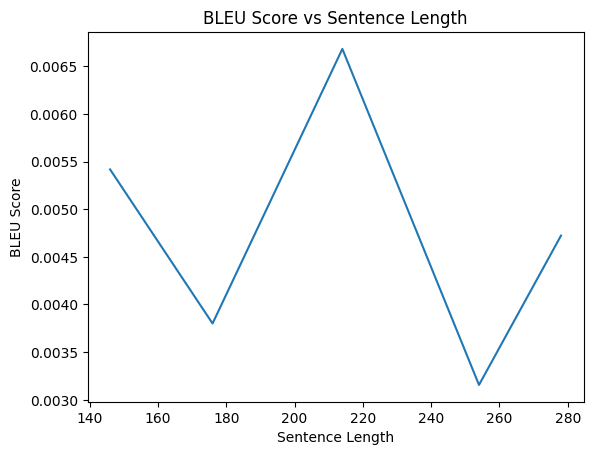

In [97]:
non_zeros = [ (k, v["bleu"]) for k, v in bleus.items() if v["bleu"] > 0.0]
sorted_non_zeros = sorted(non_zero)

import matplotlib.pylab as plt

plt.plot([k for k, v in sorted_non_zeros], [v for k, v in sorted_non_zeros])
plt.xlabel("Sentence Length")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Sentence Length")
plt.show()